In [2]:
import torch 
from torch import nn
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import kurtosis
from prettytable import PrettyTable
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

else:
    device = torch.device("cpu")

#Rough Estimate made Graphically
def MultiplyPE(pe):
    pe = pe * 25
    return pe

#Scales PE for 2012 y intercept
def ScalePERatio(df):
    df['Shiller PE Ratio'] = df['Shiller PE Ratio'].apply(MultiplyPE)
    return df

    
def BuildSandPDataSet():
    df = pd.read_csv("SandP500Data.csv", sep = ',')
    #df.drop('Volume', inplace = True, axis=1)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    return df

def BuildShillerPeDataSet():
    df = pd.read_csv("ShillerPERatio.csv", sep = ',', skiprows = [0])
    df = df.rename(columns={'DateTime': 'Date'})
    #df['Date'] = df['Date'].apply(ChangeDateShiller)
    df = df.sort_index(axis=0,ascending=False).reset_index()
    df.drop('index', inplace = True, axis = 1)
    return df

def BuildDataset():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    df = pd.merge(SP, PE, how="inner", on=["Date"])
    df = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Shiller PE Ratio', 'Close']]
    return df

def MergeByDate(df1, df2):
    dfinal = df1.merge(df2, on="Date", how = 'inner')
    return dfinal


#Looks like the derivatives of each are correlated
#Even though maybe the magnitudes are not
def GraphPEToClose(SandPData, PEData, logy = True):
    if logy == False:
        #PEData = ScalePERatio(PEData)
        title = "Graph of S&P and Schiller PE"
    else:
         title = "Graph of S&P and Schiller PE"
       
    dfinal = MergeByDate(SandPData, PEData)
    dfinal[:].plot(x='Date', y=['Close', 'Shiller PE Ratio'], figsize=(10,5), logy = logy, title = title, grid=True)

def PEGraph():
    SP = BuildSandPDataSet()
    PE = BuildShillerPeDataSet()
    GraphPEToClose(SP, PE)
    
def BuildInputSequence(dataset, window, prediction):
    
    features = []
    labels = []

    for i in range(0, len(dataset) - window + 1 - prediction):
        feature = []
        label = []
        for j in range(0, window):
            row = []
            row.append(np.log(dataset['Open'][i + j]))
            row.append(np.log(dataset['High'][i + j]))
            row.append(np.log(dataset['Low'][i + j]))
            row.append(np.log(dataset['Volume'][i + j]))
            row.append(np.log(dataset['Shiller PE Ratio'][i + j]))
            row.append(np.log(dataset['Close'][i + j]))
            feature.append(row)

        for j in range(0, prediction):
            label.append(np.log(dataset['Open'][i + window + j]))
            label.append(np.log(dataset['High'][i + window + j]))
            label.append(np.log(dataset['Low'][i + window + j]))
            label.append(np.log(dataset['Volume'][i + window + j]))
            label.append(np.log(dataset['Shiller PE Ratio'][i + window + j]))
            label.append(np.log(dataset['Close'])[i + window + j])

        features.append(feature)
        labels.append(label)
        
    return [features, labels]

def TrainTestDataset(window = 1, prediction = 1):
    df = BuildDataset()
    a = BuildInputSequence(df, window, prediction)
   
    X_train, X_test, Y_train, Y_test = train_test_split(a[0], a[1], test_size = 0.2)
    
    return [X_train, Y_train, X_test, Y_test]


class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.rnn = nn.RNN(input_size, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        return hidden
    
def Train(Model, X_train, Y_train, epochs, batchSize, learningRate, Validation = True):
    minValidLoss = np.inf
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Model.parameters(), lr=learningRate)
    
    validationSet = None
    validationLoader = None
    
    if(Validation):
        X_train, val_X, Y_train, val_Y = train_test_split(X_train, Y_train, test_size = 0.2)
        validationSet = torch.utils.data.TensorDataset(val_X, val_Y)
        validationLoader = torch.utils.data.DataLoader(dataset=validationSet, batch_size=batchSize, shuffle=True)
    
    
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataLoader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batchSize, shuffle=True)
    
    
    
    
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_steps = 0
        Model.train()
        for i, (data, label) in enumerate(dataLoader):
            data = data.to(device)
            label = label.type(torch.float32)
            label = label.to(device)

            output, hidden = Model(data)
            #output = output.squeeze(1)
            output = output.float()
            label = label.float()
            #print(str(data), "\n")
            #print(str(output), "\n")
            #print(str(label), "\n")
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_steps += 1
            
            #if(loss.item() < 0.01):
                #print("Done Training..")
                #return
        if epoch % 10 == 0:
            print("Epoch: " + str(epoch) + " Loss: " + str(loss.item()))
            
        #Validation
        if(Validation):
            val_loss = 0.0
            Model.eval()
            for i, (data, label) in enumerate(validationLoader, 0):
                with torch.no_grad():
                    data = data.to(device)
                    label = label.type(torch.float32)
                    label = label.to(device)

                    output, hidden = Model(data)
                    output = output.float()
                    label = label.float()
                    loss = criterion(output, label)
                    val_loss = loss.item() * data.size(0)

            if minValidLoss > val_loss:
                print("Validation Loss Decreased to: ", val_loss, "\n")
                minValidLoss = val_loss
                torch.save(Model.state_dict(), 'saved_model.pth')
   
    if(Validation):      
        Model.load_state_dict(torch.load('saved_model.pth'))
        
            
        
        
    
#rnn = RNN(6, 32, 1)
D = TrainTestDataset(1)
X_train, Y_train, X_test, Y_test = D[0], D[1], D[2], D[3]


X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

X_train.shape


Model = RNN(6, 6, 32, 1)
Model = Model.to(device)

Train(Model, X_train, Y_train, 200, 10, 0.01, True)



#Getting Input size[30]
#Expecting Output size [10, 1]

#Getting Input size[12]
#Expecting Output size [4, 1]


Cuda Device Available
Name of the Cuda Device:  NVIDIA GeForce RTX 3060 Laptop GPU
GPU Computational Capablity:  (8, 6)
Epoch: 0 Loss: 26.532264709472656
Epoch: 10 Loss: 0.8962635397911072
Epoch: 20 Loss: 0.8148296475410461
Epoch: 30 Loss: 0.3815251886844635
Epoch: 40 Loss: 0.7665108442306519
Epoch: 50 Loss: 0.1355390101671219
Epoch: 60 Loss: 0.10994093865156174
Epoch: 70 Loss: 0.048044439405202866
Epoch: 80 Loss: 0.025454962626099586
Epoch: 90 Loss: 0.06207685545086861
Epoch: 100 Loss: 0.036934614181518555
Epoch: 110 Loss: 0.10821572691202164
Epoch: 120 Loss: 0.032367102801799774
Epoch: 130 Loss: 0.05089598149061203
Epoch: 140 Loss: 0.029450450092554092
Epoch: 150 Loss: 0.04697418957948685
Epoch: 160 Loss: 0.020029086619615555
Epoch: 170 Loss: 0.020646221935749054
Epoch: 180 Loss: 0.03879428654909134
Epoch: 190 Loss: 0.01581169292330742


In [51]:
def PredictAhead(M, XInit, FarAhead):
    output = XInit
    for _ in range(FarAhead):
        output, hidden = M(output)
        output = torch.Tensor(np.array([output.cpu().detach().numpy()])).to(device)
        #print(output)
    output = output.cpu().detach().numpy()
    return math.e**output[-1][-1][-1]

PredictAhead(Model, X_train[0:5].to(device), 7)


1260.7637428411256

In [3]:
def errorCalc(length, X, pred_length, dates, text, table):
    e = math.e
    errors = []
    
    for i in range(length):
        pred = PredictAhead(Model, X[i: i + 5].to(device), pred_length)
        errors.append(abs(float((pred - e**X[i + 5 + pred_length][-1][-1]) / e**X[i + 5 + pred_length][-1][-1])))
    
    if (len(X) > 300):
        d = {'Dates': dates[:len(errors)], 'Errors': errors}
    else:
        d = {'Dates': dates[(len(dates) - len(errors)):len(dates)], 'Errors': errors}
        
    
    df = pd.DataFrame(data = d)
    

    mean = sum(errors) / len(errors)
    var = sum([((x - mean) ** 2) for x in errors]) / len(errors)
    std = var ** 0.5
    skewness = skew(errors)
    kurt = kurtosis(errors)
    
    df.plot(x = 'Dates', y = 'Errors', figsize = (20, 5), grid = True, title = text)
    table.add_row([text, mean, std, skewness, kurt])
    return mean
    

def Test(M):
    e = math.e
    
    data = BuildDataset().to_dict('split')['data']
    
    dates = []
    for i in range(len(data)):
        dates.append(data[i][0])
        
    myTable = PrettyTable(field_names = ["Category", "Mean", "STD", "Skewness", "Kurtosis"])
    myTable.title = "Error Statistics"
        
 
    #for one day prediction on train data
    errorCalc(len(X_train) - 7, X_train, 1, dates, "Train data with one day prediction", myTable)
    
        
    #for one day prediction on test data
    errorCalc(len(X_test) - 7, X_test, 1, dates, "Test data with one day prediction", myTable)
    
    
    #for two day prediction on train data
    errorCalc(len(X_train) - 8, X_train, 2, dates, "Train data with two days prediction", myTable)
    
    
    #for two day prediction on test data
    errorCalc(len(X_test) - 8, X_test, 2, dates, "Test data with two days prediction", myTable)

    
    #for three day prediction on train data
    errorCalc(len(X_train) - 9, X_train, 3, dates, "Train data with three days prediction", myTable)
    
    
    #for three day prediction on test data
    errorCalc(len(X_test) - 9, X_test, 3, dates, "Test data with three days prediction", myTable)
    
    
    #for four day prediction on train data
    errorCalc(len(X_train) - 10, X_train, 4, dates, "Train data with four days prediction", myTable)
    
    
    #for four day prediction on test data
    errorCalc(len(X_test) - 10, X_test, 4, dates, "Test data with four days prediction", myTable)
    
    
    print(myTable)
    
        

+---------------------------------------------------------------------------------------------------------------------------+
|                                                      Error Statistics                                                     |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|                Category               |        Mean        |        STD         |      Skewness      |      Kurtosis      |
+---------------------------------------+--------------------+--------------------+--------------------+--------------------+
|   Train data with one day prediction  | 1.2559146333107576 | 1.811715183450504  | 2.6905236976462583 | 7.434756927411488  |
|   Test data with one day prediction   | 1.0205362816000494 | 1.2509711163072688 | 2.540173736014568  | 6.132642175171775  |
|  Train data with two days prediction  | 0.9279149898338592 | 1.122371683470924  | 2.876262165789374  | 9.44675952383

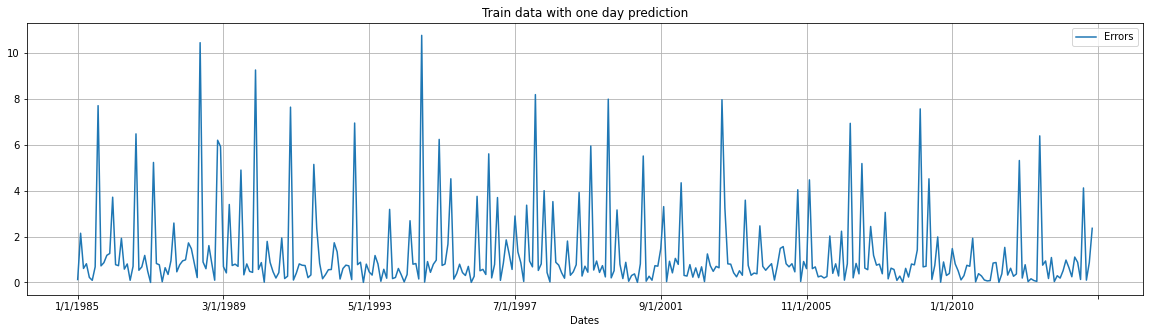

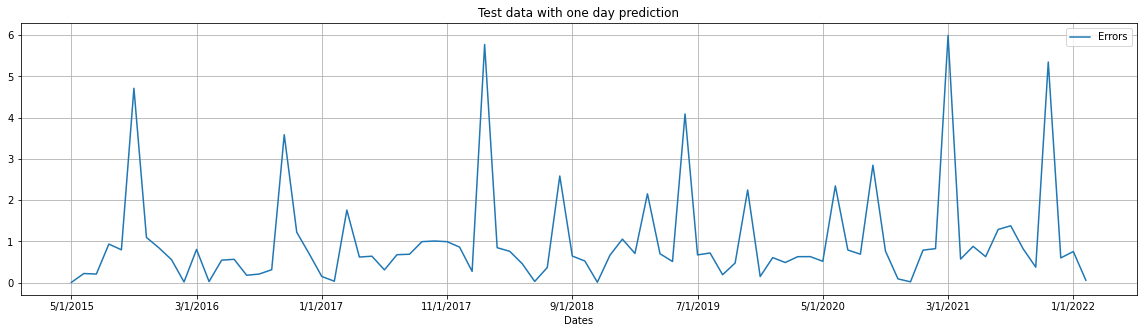

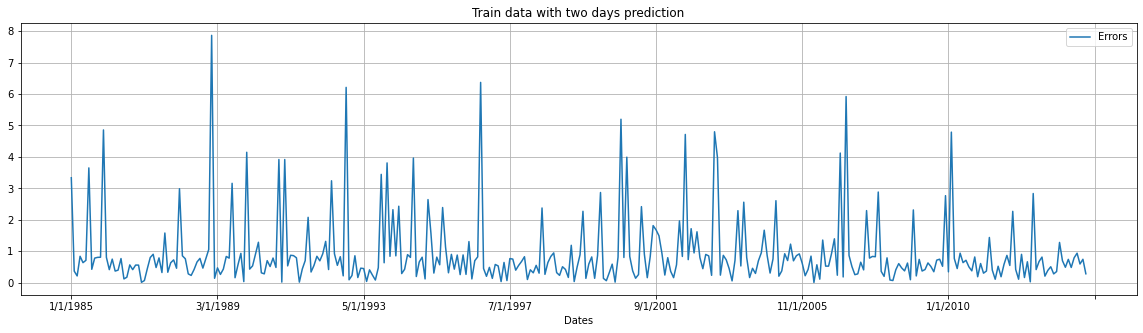

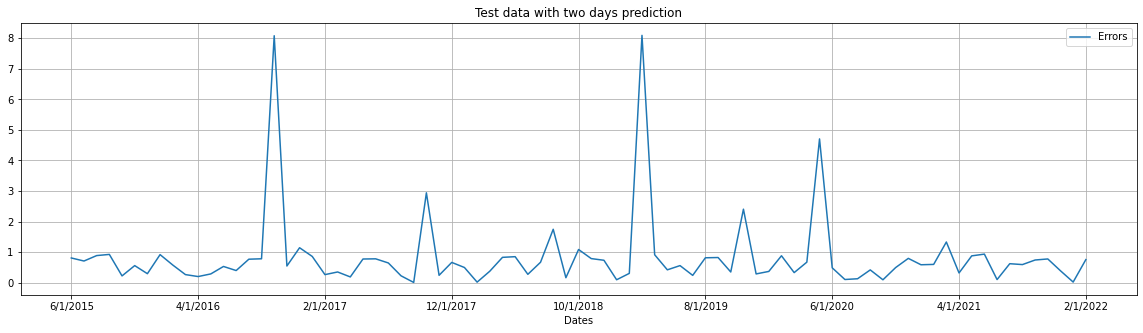

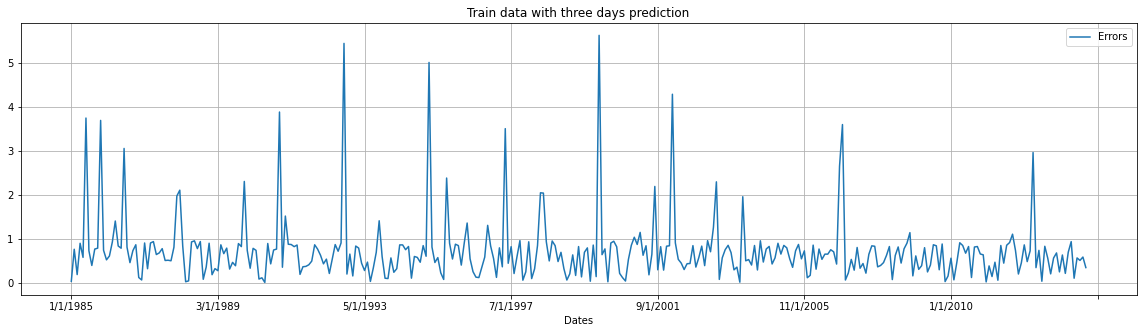

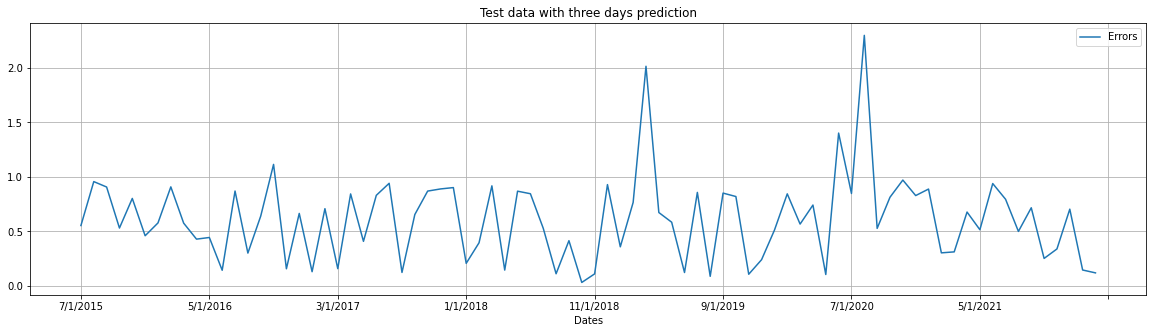

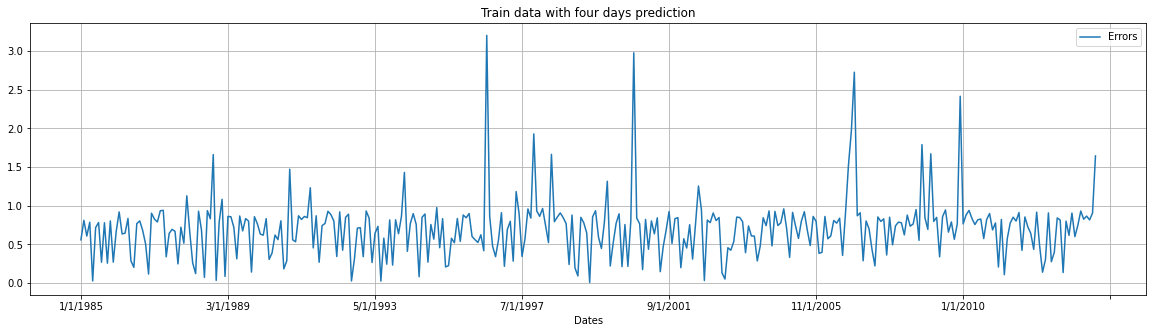

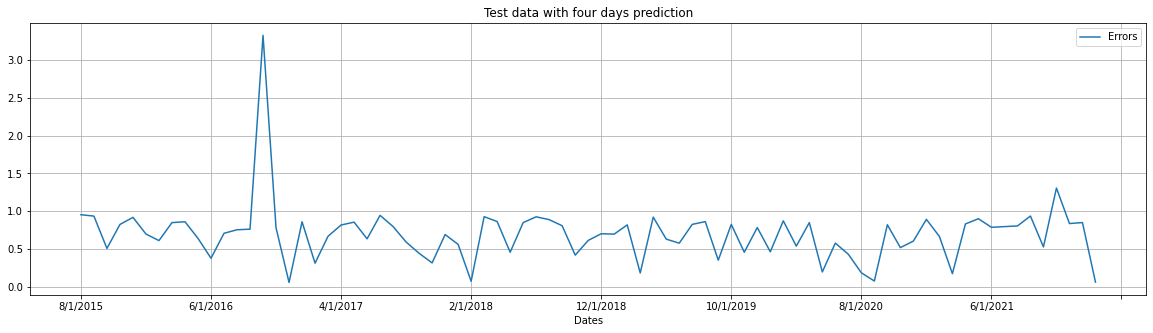

In [49]:
Test(Model)
